# get aggregated tax from gather.
- How much additional content found when adding new MAGs
- What species yield the most additional content

In [35]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np


In [2]:
tax_out_folder = Path("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/tax_metag/summary")

all_agg = []

In [3]:
for csv_file in tax_out_folder.glob("*.csv"):
    # Load CSV (you can use chunksize if files are huge)
    df = pd.read_csv(csv_file)
    agg = (
        df[(df["rank"] == "species") & (df["lineage"] != "unclassified")]
        .assign(weighted_expr=df["f_weighted_at_rank"] * df["total_weighted_hashes"] * 10000)
        .groupby("lineage")
        .agg(avg_fraction=("weighted_expr", "mean"), n_found=("lineage", "size"))
        .reset_index()
    )

    # Append result
    all_agg.append(agg)

In [4]:
result = pd.concat(all_agg, ignore_index=True)
result.head()

,lineage,avg_fraction,n_found
0,d__Archaea;p__Halobacteriota;c__Methanosarcini...,10000.0,1
1,d__Archaea;p__Methanobacteriota;c__Methanobact...,90000.0,1
2,d__Archaea;p__Methanobacteriota;c__Methanobact...,10000.0,1
3,d__Archaea;p__Methanobacteriota;c__Methanobact...,20000.0,1
4,d__Archaea;p__Methanobacteriota;c__Methanobact...,610000.0,1


In [5]:
# group accross all the tax files
df_final = (
    result.groupby("lineage")
    .agg(avg_fraction=("avg_fraction", "mean"), n_found=("n_found", "sum"))
    .reset_index()
)
len(df_final)

55702

In [6]:
df_final['n_found'].value_counts()

n_found
1       14266
2        5902
3        3460
4        2419
5        1851
        ...  
2371        1
2187        1
1526        1
1146        1
1159        1
Name: count, Length: 2257, dtype: int64

In [ ]:
# bc i want a copy of the file
df_final.to_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/tax_metag/251105_tax_species.gtdbmag.summary.csv', index=False)

In [10]:
df1 = pd.read_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/tax_metag/250830_tax_species.gtdb.summary.csv')
df2 = df_final
# rename
df1 = df1.rename(columns={"n_found": "n_found_gtdb"})
df1 = df1.rename(columns={"avg_fraction": "avg_fraction_gtdb"})

df2 = df2.rename(columns={"n_found": "n_found_gtdbmag"})
df2 = df2.rename(columns={"avg_fraction": "avg_fraction_gtdbmag"})

In [12]:
df =pd.merge(df1, df2, on="lineage", how="outer")
df = df.fillna(0)

df = df[df["lineage"] != "unclassified"]

In [14]:
# species col
df["species"] = df["lineage"].str.split(";s__").str[-1]
df["genus"] = df["lineage"].str.split(";g__").str[1].str.split(";").str[0]

In [15]:
len(df)

56264

In [16]:
df["n_found_gtdbmag"] = df["n_found_gtdbmag"].astype(int)

In [ ]:
# color the core spp
# what is 99%. Rouded to .985 (3216* 0.985= 3169)
n_metaG =  3169
core_spp = df[(df["n_found_gtdbmag"] >= n_metaG)]
len(core_spp)

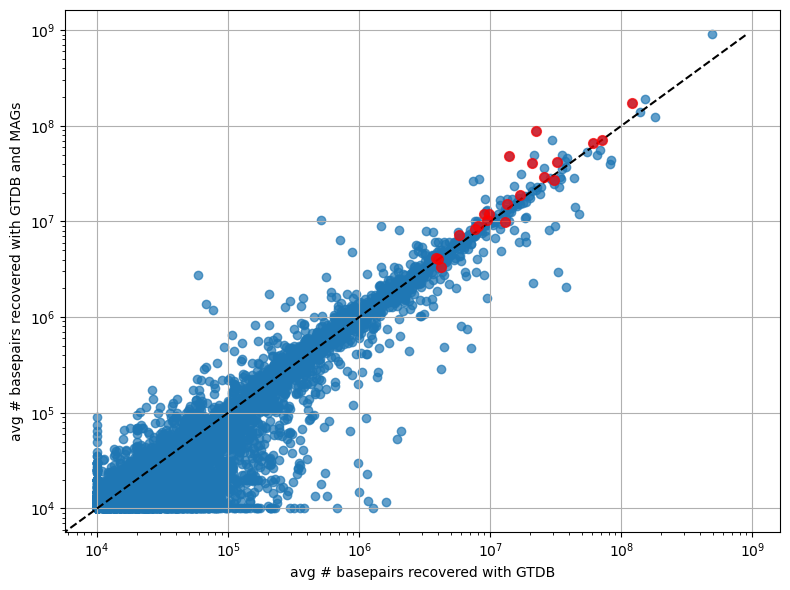

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(df["avg_fraction_gtdb"], df["avg_fraction_gtdbmag"], alpha=0.7)
plt.xlabel("avg_fraction_gtdb")
plt.ylabel("avg_fraction_gtdbmag")
lims = [min(df["avg_fraction_gtdb"].min(), df["avg_fraction_gtdbmag"].min()),
        max(df["avg_fraction_gtdb"].max(), df["avg_fraction_gtdbmag"].max())]

plt.plot(lims, lims, linestyle="--", color="black")
plt.scatter(core_spp["avg_fraction_gtdb"], core_spp["avg_fraction_gtdbmag"],
            color="red", s=50, zorder=3, alpha=0.7)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("avg # basepairs recovered with GTDB")
plt.ylabel("avg # basepairs recovered with GTDB and MAGs")
#plt.title("Scatterplot of avg_gtdb vs avg_gtdbmag per species")
plt.grid(True)
plt.tight_layout()
plt.show()


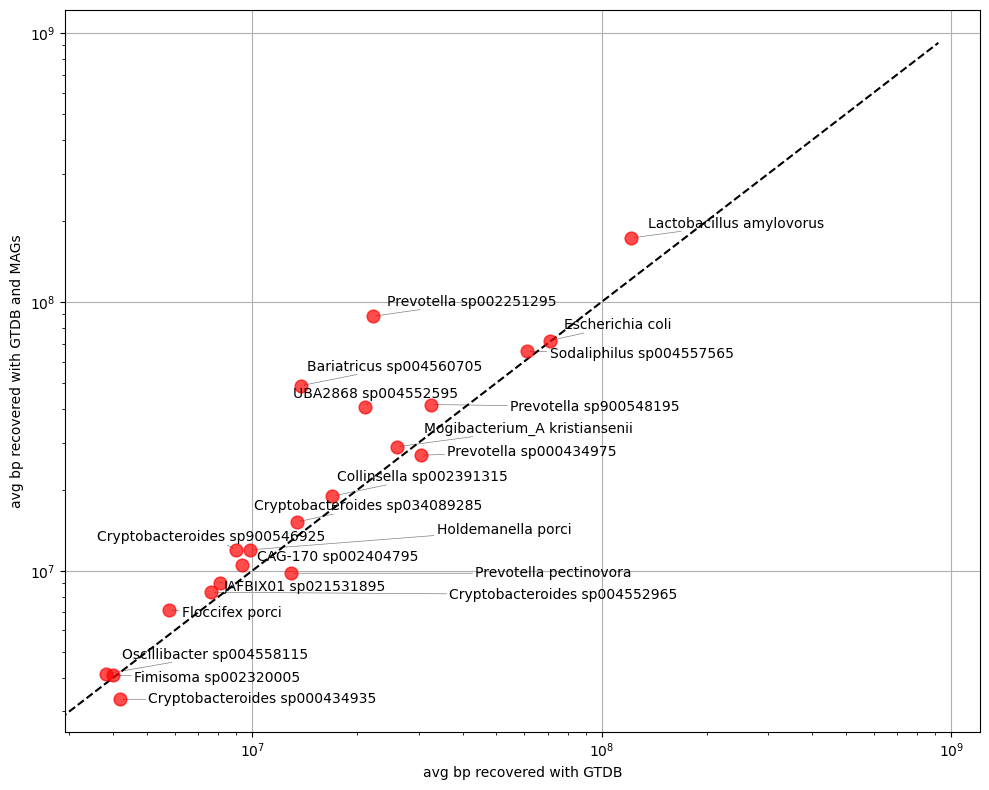

In [30]:
# plot only core spp

plt.figure(figsize=(10,8))
#plt.scatter(df["avg_fraction_gtdb"], df["avg_fraction_gtdbmag"], alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("avg bp recovered with GTDB")
plt.ylabel("avg bp recovered with GTDB and MAGs")

lims = [min(df["avg_fraction_gtdb"].min(), df["avg_fraction_gtdbmag"].min()),
        max(df["avg_fraction_gtdb"].max(), df["avg_fraction_gtdbmag"].max())]

plt.plot(lims, lims, linestyle="--", color="black")

# highlight top10
plt.scatter(core_spp["avg_fraction_gtdb"], core_spp["avg_fraction_gtdbmag"],
            color="red", s=85, zorder=3, alpha=0.7)


texts = []
for i, row in core_spp.iterrows():
    label = f"{row['species']}"
    texts.append(
        plt.text(row["avg_fraction_gtdb"], row["avg_fraction_gtdbmag"], label,
                 fontsize=10, ha="left", va="bottom")
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

plt.grid(True)
plt.tight_layout()


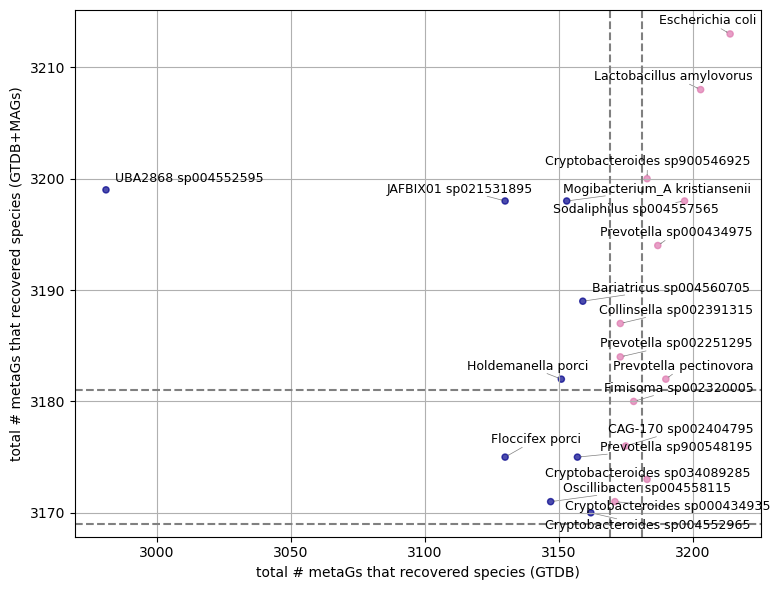

In [45]:
# Would it have been core without binning?
plt.figure(figsize=(8,6))
colors = np.where(core_spp["n_found_gtdb"] < 3169, "darkblue", "#de77ae")

plt.scatter(core_spp["n_found_gtdb"], core_spp["n_found_gtdbmag"],
            c=colors, alpha=0.7, s=20)

texts = []
for i, row in core_spp.iterrows():
    label = f"{row['species']}"
    texts.append(
        plt.text(row["n_found_gtdb"], row["n_found_gtdbmag"], label,
                 fontsize=9, ha="left", va="bottom")
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5,))
    

# horizontal
plt.axhline(y=3169, linestyle="--", color="gray")
plt.axhline(y=3181, linestyle="--", color="gray")

# vertical
plt.axvline(x=3169, linestyle="--", color="gray")
plt.axvline(x=3181, linestyle="--", color="gray")

plt.xlabel("total # metaGs that recovered species (GTDB)")
plt.ylabel("total # metaGs that recovered species (GTDB+MAGs)")
#plt.title("Scatterplot of avg_gtdb vs avg_gtdbmag per species")
plt.grid(True)
plt.tight_layout()
# plt.show()
